## Финальный отчёт по проекту  
## "Прогнозирование оттока клиентов"
### Цели и задачи проекта

Цель проекта - прогнозирование оттока клиентов телекоммуникационной компании Orange. Для её решения необходимо предсказать вероятность  отказа клиента от услуг данной компании в течение некоторого заданного промежутка времени.  

Задача проекта - найти клиентов, склонных к оттоку, чтобы выявить причины оттока. Это способствует решению проблем пользователей, попавших в группу риска, и их удержанию в числе клиентов - процент оттока снижается.  

Для достижения этой цели обучается модель, прогнозирующая вероятность того, что пользователь покинет сервис. В данном случае решается задача бинарной классификации, где целевой класс - клиенты, покидающие сервис. Вероятность того, что пользователь принадлежит целевому классу - это вероятность оттока (вероятность того, что клиент откажется от услуг компании).  


### Методика измерения качества и критерий успеха

Модель оценивается на основании метрики AUC-ROC - площади под ROC-кривой. Модель тестируется методом кросс-валидации. Классы в исходной выборке несбалансированы, поэтому необходима стратификация - разбиение выборки таким образом, чтобы в каждом тестовом блоке сохранялось соотношение классов. Чем выше показатель AUC-ROC, тем качественнее классификатор.  
### Техническое описание решения  
Данные для работы предоставлены без описания. Известно, что они включают 230 признаков, первые 190 - числовые, остальные - категориальные. В наборе данных отсутствует большое количество значений. Прежде чем строить модель, необходимо обработать данные: существить преобразовывание категориальных переменных в числовые, заполнить пропущенные значения и провести другие преобразования для улучшения качества модели.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

Загрузка данных.

In [2]:
train = pd.read_csv('orange_small_churn_train_data.csv', index_col = 0)

Выделение числовых и категориальных признаков и фильтрация признаков, содержащих только нулевые значения.

In [3]:
num = np.array(train.columns[:190])
cat = np.array(train.columns[190:230])
nums = np.array(num[np.array(pd.notnull(train[num]).any())])
cats = np.array(cat[np.array(pd.notnull(train[cat]).any())])

Разбиение данных на числовые, категориальные и целевую переменную с меткой класса (у последнего объекта отсутствует метка - исключаем его).  


Заполнение пропущенных числовых значений средними по столбцам, а категориальных - 'NаN'.

In [7]:
numeric = train[nums][:-1]
categoric = train[cats][:-1]
y_train = train['labels'][:-1]
numeric = numeric.fillna(numeric.mean())
categoric = categoric.fillna('NaN')

Кодирование категориальных признаков частотами: каждое уникальное значение признака кодируется целым числом - сколько раз оно присутсвует в данном признаке. Объединяем числовые и категориальные данные.

In [8]:
for i in cats:
    freq = categoric[i].value_counts()
    categoric[i] = np.array([freq[x] for x in categoric[i]])

Добавим к каждому признаку дополнительный признак с индикатором того, пропущено значение или нет, и объединим все данные.

In [14]:
numeric_isnull = pd.isnull(train[nums][:-1]).astype(int)
categoric_isnull = pd.isnull(train[cats][:-1]).astype(int)
X_train = pd.concat([numeric, categoric, numeric_isnull, categoric_isnull], axis = 1)


### Выводы о качестве модели
Оценим качество с помощью кросс-валидации и найдём среднее значение AUC-ROC.  


In [24]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
clf = StratifiedKFold(3)
scores = cross_val_score(GradientBoostingClassifier(learning_rate = 0.1, max_depth = 2), 
X_train, y_train, scoring = 'roc_auc', cv = clf, n_jobs = -1)
print('Среднее значение AUC-ROC:', scores.mean())

Среднее значение AUC-ROC: 0.7364229948769649




Построим кривые обучения - постепенно наращиваем размер обучающей выборки и смотрим, как меняется качество на обучающей и тестовой выборках.


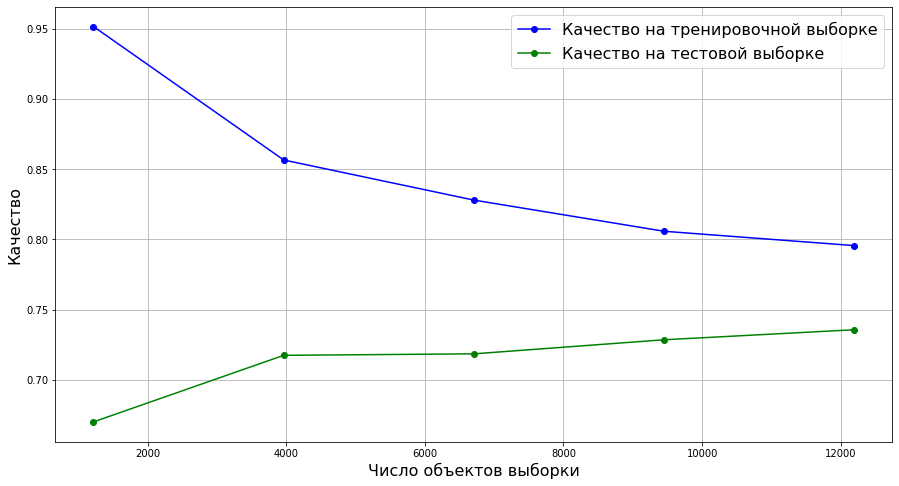

In [30]:
from sklearn.model_selection import learning_curve
train_sizes_abs, train_scores, test_scores = learning_curve(GradientBoostingClassifier(learning_rate = 0.1, max_depth = 2), 
X_train, y_train, cv = StratifiedKFold(3), scoring = 'roc_auc', n_jobs = -1)
train_scores_mean = np.mean(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
plt.figure(figsize = (15, 8))
plt.xlabel('Число объектов выборки', fontsize = 16)
plt.ylabel('Качество', fontsize = 16)
plt.grid()
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color = 'b', label = 'Качество на тренировочной выборке')
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color = 'g', label = 'Качество на тестовой выборке')
plt.legend(fontsize = 16)
plt.show()

Видим, что с увеличением объёма данных качество на тестовой выборке увеличивается, а на тренировочной - уменьшается. Следовательно, увеличение объёма выборки увеличит качество модели.  

Найдём 50 наиболее важных признаков и отсортируем их в порядке убывания значимости для модели.

In [31]:
clf = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 2)
clf.fit(X_train, y_train)
features = pd.DataFrame({'Признак' : X_train.columns, 'Значимость признака' : clf.feature_importances_})
features.sort_values('Значимость признака', ascending = False).reset_index(drop = True)[:50]

,Признак,Значимость признака
0,Var126,0.212732
1,Var189,0.083566
2,Var113,0.072711
3,Var192,0.059899
4,Var218,0.056140
5,Var126,0.048019
6,Var199,0.043079
7,Var74,0.039619
8,Var217,0.038772
9,Var13,0.031297


Наиболее важные для модели признаки - Var126, Var189, Var113, Var192, Var218.  
### Ожидаемый экономический эффект от использования модели

Для расчёта экономического эффекта введём параметры:
- ARPU - средний доход от одного клиента за месяц
- retention_cost - средние расходы на удержание одного клиента
- top - максимальный процент клиентов, склонных к оттоку по  предсказаниям модели, которые будут участвовать в кампании по удержанию
- chance - вероятность, с которой клиент будет удержан
- time - среднее время (в месяцах), на которое клиент будет удержан, если примет наше предложение

Экономический эффект зависит от качества модели. Выберем клиентов, склонных к оттоку согласно предсказанию, и запишем в переменную result истинные значения целевого класса для них.


In [32]:
y_pred = clf.predict(X_train)
y_prob = clf.predict_proba(X_train)[:, 1]
labels = pd.DataFrame({'prediction' : y_pred, 'chance' : y_prob, 'result' : np.array(y_train)})
pred = labels[labels.prediction == 1].sort_values('chance', ascending = False).reset_index(drop = True)
results = np.array(pred.result)

Формула расчёта экономического эффекта в зависимости от исходных параметров:

In [33]:
def effect(ARPU, retention_cost, chance, top, time):
    users_number = int(np.floor(top/ 100. * len(results)))
    churned = sum(results[:users_number] == 1)
    accepted = int(np.floor(chance * churned))
    cost = users_number * retention_cost
    income = accepted * ARPU * time
    return income - cost

Фиксируем параметры: ARPU = 1000, retention_cost = 100, chance = 0.3, time = 3; строим график изменения экономического эффекта в зависимости от параметра top.

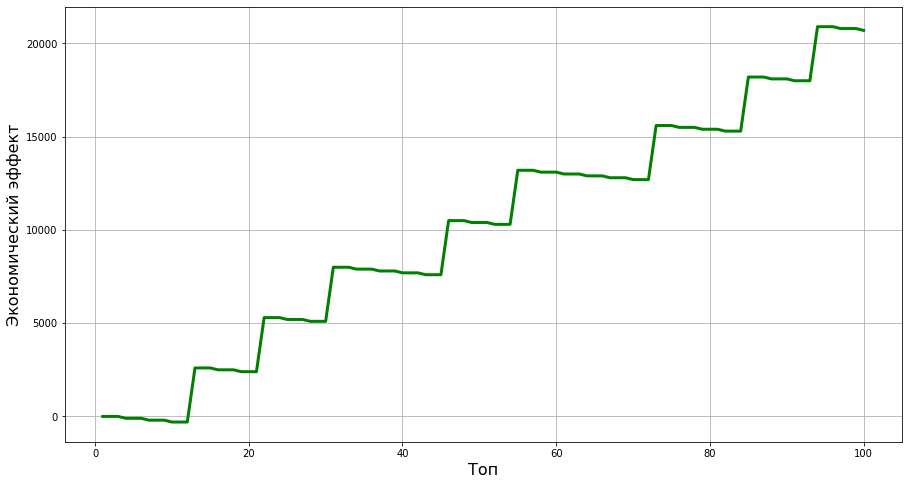

In [37]:
tops = np.arange(1, 101)
effects = np.array([effect(1000, 100, 0.3, top, 3) for top in tops])
plt.figure(figsize = (15, 8))
plt.grid()
plt.plot(tops, effects, linewidth = 3, color = 'g')
plt.xlabel('Top', fontsize = 16)
plt.ylabel('Экономический эффект', fontsize = 16)
plt.show()

Из графика видно что с увеличением Top растёт экономический эффект. Найдём оптимальное значение top клиетнов при заданных параметрах и экономический эффект.

In [42]:
i = np.argsort(effects)[-1]
print(f'Оптимальное значение top: {tops[i]}%.')
print('Экономический эффект:', effects[i])

Оптимальное значение top: 96%.
Экономический эффект: 20900


### Итоги
Данную модель можно использовать для выявления клиентов, склонных к отказу от услуг компании, и принимать меры по их удержанию.   
Для улучшения качества работы модели нужно увеличить объём данных для обучения. У компании с течением времени появляются новые услуги, поэтому необходимо добавлять в модель новые признаки, и удалять неактуальные - для эффективной работы модель должна регулярно обновляться. Также возможно найти новые причины оттока клиентов, сформировать на их основе гипотезы, осуществить их проверку, добавив характеризующие их признаки в модель.  